<a href="https://colab.research.google.com/github/kwarrenw/PytorchCode/blob/main/KarlWilson_MNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necessary PyTorch libraries and modules


In [220]:
# Import necessary PyTorch libraries and modules
import torch # Core PyTorch library for tensor computation
import torch.nn as nn # Neural network module, contains pre-built layers like Conv2d, Linear, etc.
from torch.utils.data import DataLoader # Utility for loading data in batches
import torchvision.transforms as transforms # Common image transformations
import torchvision.datasets # Datasets like MNIST, CIFAR10, etc.
from torch.utils.data import Subset # To select a subset of a dataset
from torch.autograd import Variable # Deprecated, but used for tracking gradients (modern PyTorch uses tensors with requires_grad=True)
import matplotlib.pyplot as plt # For plotting graphs
import numpy as np # For numerical operations, often used with PyTorch tensors
import torch.nn.functional as F # Functional interface for common operations like activation functions, pooling, etc.

# define the function of displaying multiple images
def show_images(images) -> None:
    # Get the number of images in the batch
    n: int = images.size(0)

    # Create a figure and subplots
    f = plt.figure(figsize=(24, 6))
    # Iterate through the images and plot them
    for i in range(n):
        # Add a subplot
        f.add_subplot(1, n, i + 1)
        # Display the image, squeezing any singleton dimensions and using a grayscale colormap
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        # Turn off the axis
        plt.axis('off')

    # Show the plot
    plt.show(block=True)

# define the function of displaying multiple images with predicted labels
def show_images_withPred(images,label,pred,conf) -> None:
    # Get the number of images in the batch
    n: int = images.size(0)

    # Create a figure and subplots
    f = plt.figure(figsize=(24, 6))
    # Iterate through the images and plot them
    for i in range(n):
        # Add a subplot
        f.add_subplot(1, n, i + 1)
        # Display the image, squeezing any singleton dimensions and using a grayscale colormap
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        # Set the title to show the true label and predicted label
        plt.title("{} -> {}".format(label[i], pred[i]))
        # You could also include confidence here:
        #plt.title("Conf:{} \n {} -> {}".format(conf[i][pred[i]]*100,label[i], pred[i]))
        # Turn off the axis
        plt.axis('off')

    # Show the plot
    plt.show(block=True)

# Hyperparameters and Data loaders

In [221]:
# Hyperparameters and Data loaders
num_epochs = 10 # Number of training epochs
num_classes = 10 # Number of output classes (0-9 for MNIST)
batch_size = 256 # Number of samples per batch
learning_rate = 0.001 # Learning rate for the optimizer


DATA_PATH = 'data/' # Path to store the dataset
MODEL_STORE_PATH = 'models/' # Path to store trained models

# transforms to apply to the data
# transforms.Compose combines multiple transforms
# transforms.ToTensor() converts a PIL Image or numpy.ndarray to a PyTorch tensor
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
# root: directory where the dataset will be downloaded
# train=True: load the training dataset
# transform: apply the defined transformations
# download=True: download the dataset if not already present
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
# train=False: load the test dataset
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
# dataset: the dataset to load
# batch_size: number of samples per batch
# num_workers: how many subprocesses to use for data loading
# shuffle=True: shuffle the training data for better generalization
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
# shuffle=False: no need to shuffle the test data
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

# neural network

In [222]:
# neural network
class ConvNet(nn.Module):
    # __init__ is the constructor of the class
    def __init__(self):
        # Call the constructor of the parent class (nn.Module)
        super(ConvNet, self).__init__()

        # Define the layers of the neural network as a sequential container
        self.classifier = nn.Sequential(
            # Flatten the input tensor from shape (batch_size, 1, 28, 28) to (batch_size, 784)
            nn.Flatten(),
            # First fully connected layer: 784 input features, 128 output features
            nn.Linear(28*28, 128),
            # Second fully connected layer: 128 input features, 64 output features
            nn.Linear(128, 64),
            # Third fully connected layer: 64 input features, 10 output features (for 10 classes)
            nn.Linear(64, 10)
        )

    # forward defines the forward pass of the network
    def forward(self, x):
        # Pass the input through the classifier layers
        out = self.classifier(x)

        # Return the output
        return out


# Create an instance of the ConvNet model
model=ConvNet()
# Move the model to the GPU if available
model.cuda()
# Set the model to training mode
model.train()

ConvNet(
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)

# Loss and optimizer

In [223]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss() # Define the loss function: CrossEntropyLoss is suitable for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Define the optimizer: Adam is an optimization algorithm

# Set the model to training mode

In [224]:
model.train() # Set the model to training mode
loss_list = [] # List to store loss values during training
acc_list = [] # List to store accuracy values during training
total_step = len(train_loader) # Total number of steps per epoch

for epoch in range(num_epochs): # Loop over the specified number of epochs
  for i, (images, labels) in enumerate(train_loader): # Iterate over the training data in batches
    images = images.cuda() # Move images to the GPU
    labels = labels.cuda() # Move labels to the GPU

    outputs = model(images) # Forward pass: compute predicted outputs by passing images through the model

    loss = criterion(outputs, labels) # Compute the loss between the predicted outputs and true labels
    loss_list.append(loss.item()) # Append the current loss value to the loss_list

    # Backprop and percform Adam optimisation
    optimizer.zero_grad() # Clear the gradients of the model parameters
    loss.backward() # Backpropagate the loss to compute gradients
    optimizer.step() # Update the model parameters using the optimizer

    # Track the accuracy
    total = labels.size(0) # Total number of labels in the current batch
    _, predicted = torch.max(outputs.data, 1) # Get the index of the class with the highest probability (predicted class)
    correct = (predicted == labels).sum().item() # Count the number of correct predictions in the batch
    acc_list.append(correct / total) # Append the current accuracy to the acc_list

    if (i%150 == 0): # Print training progress every 150 steps
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100)) # Print epoch, step, loss, and accuracy

Epoch [1/10], Step [0/235], Loss: 2.3161, Accuracy: 8.20%
Epoch [1/10], Step [150/235], Loss: 0.3639, Accuracy: 91.02%
Epoch [2/10], Step [0/235], Loss: 0.2570, Accuracy: 91.41%
Epoch [2/10], Step [150/235], Loss: 0.2782, Accuracy: 91.80%
Epoch [3/10], Step [0/235], Loss: 0.2251, Accuracy: 93.36%
Epoch [3/10], Step [150/235], Loss: 0.3236, Accuracy: 92.19%
Epoch [4/10], Step [0/235], Loss: 0.1716, Accuracy: 93.75%
Epoch [4/10], Step [150/235], Loss: 0.3142, Accuracy: 92.19%
Epoch [5/10], Step [0/235], Loss: 0.1626, Accuracy: 94.92%
Epoch [5/10], Step [150/235], Loss: 0.3138, Accuracy: 91.80%
Epoch [6/10], Step [0/235], Loss: 0.3456, Accuracy: 94.53%
Epoch [6/10], Step [150/235], Loss: 0.2795, Accuracy: 92.19%
Epoch [7/10], Step [0/235], Loss: 0.3771, Accuracy: 93.36%
Epoch [7/10], Step [150/235], Loss: 0.2485, Accuracy: 94.92%
Epoch [8/10], Step [0/235], Loss: 0.2298, Accuracy: 92.58%
Epoch [8/10], Step [150/235], Loss: 0.3205, Accuracy: 89.84%
Epoch [9/10], Step [0/235], Loss: 0.2937,

# Set the model to evaluation mode

In [225]:
# Set the model to evaluation mode
model.eval()
# Disable gradient calculation for inference
with torch.no_grad():
  # Initialize variables to track correct predictions and total samples
  correct = 0
  total = 0
  # Iterate through the test data in batches
  for images, labels in test_loader:
      # Move images to the GPU
      images = images.cuda()
      # Move labels to the GPU
      labels = labels.cuda()

      # Forward pass: compute predicted outputs
      outputs = model(images)
      # Get the predicted class with the highest probability
      _, predicted = torch.max(outputs.data, 1)
      # Update total samples
      total += labels.size(0)
      # Update correct predictions
      correct += (predicted == labels).sum().item()

# Print the accuracy of the model on the test images
print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

Accuracy of the model on the 10000 test images: 92.67999999999999 %


# Create a new figure

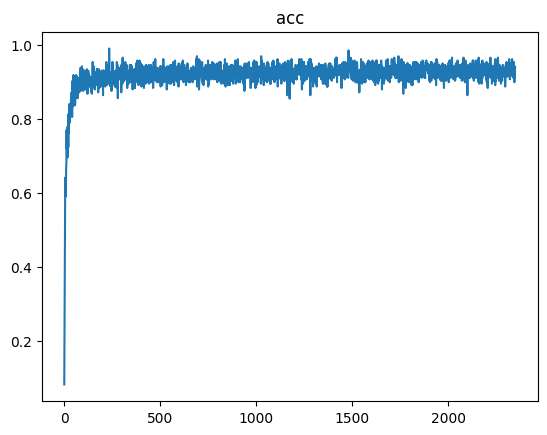

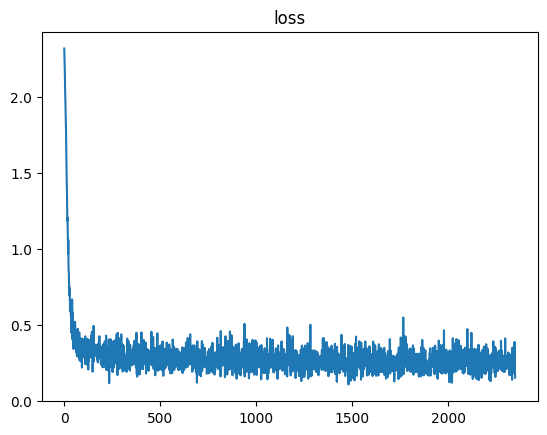

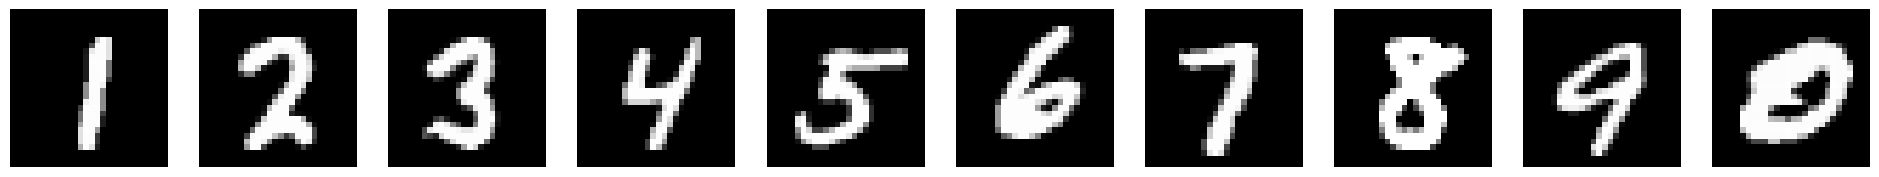

In [226]:
# Create a new figure for the accuracy plot
plt.figure()
# Plot the accuracy list
plt.plot(acc_list)
# Set the title of the accuracy plot
plt.title('acc')

# Create a new figure for the loss plot
plt.figure()
# Plot the loss list
plt.plot(loss_list)
# Set the title of the loss plot
plt.title('loss')

# Display the first 10 images from the last batch processed (images variable holds the last batch)
show_images(images[:10])

# Set the model to evaluation mode

Incorrect Predictions:


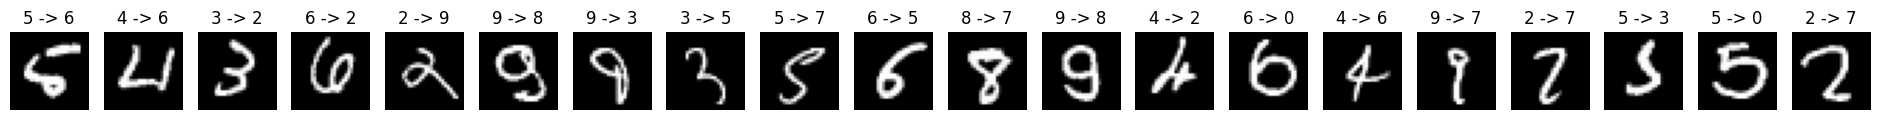

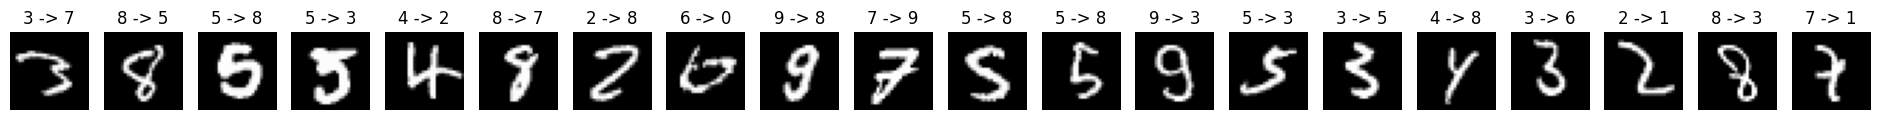

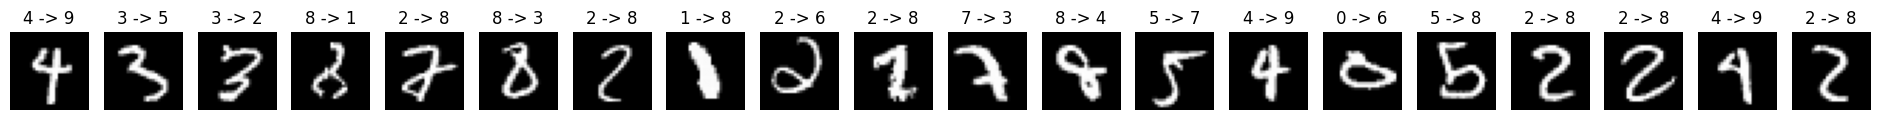

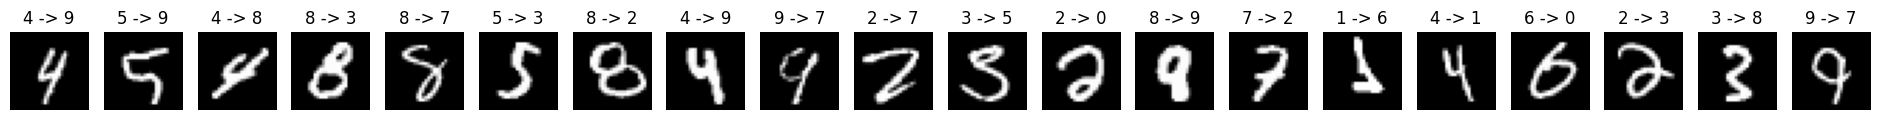


 
 Correct Predictions:


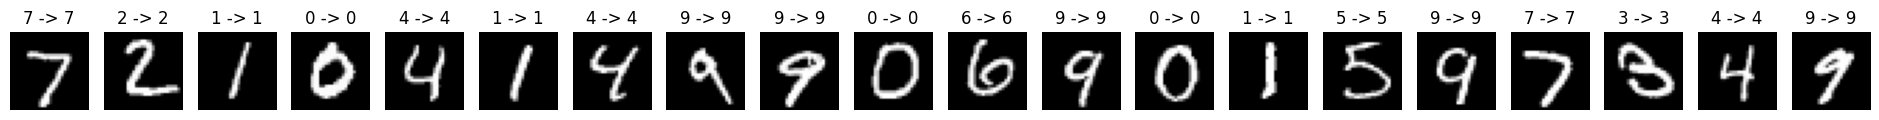

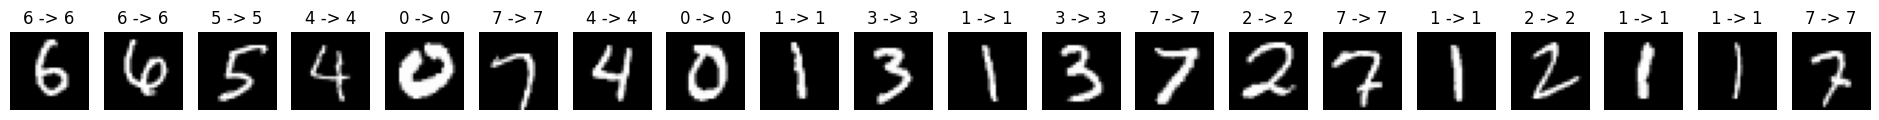

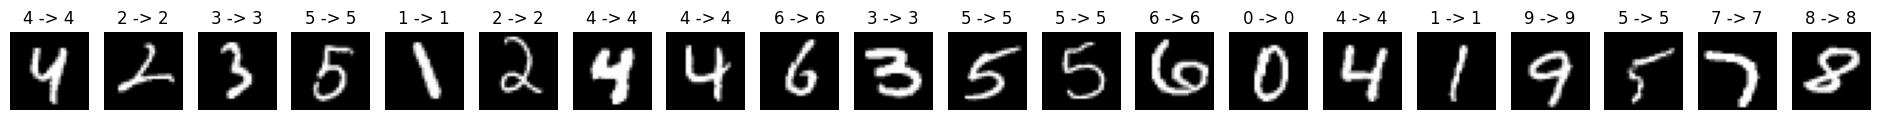

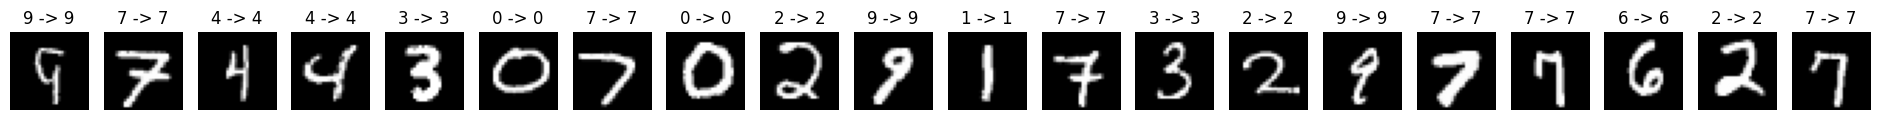

In [227]:
# Set the model to evaluation mode
model.eval()
# Disable gradient calculation for inference
with torch.no_grad():
  # Initialize variables to track correct predictions and total samples
  correct = 0
  total = 0
  # Iterate through the test data in batches
  for i, (images, labels) in enumerate(test_loader):
      # Move images to the GPU
      images = images.cuda()
      # Move labels to the GPU
      labels = labels.cuda()

      # Forward pass: compute predicted outputs
      outputs = model(images)
      # Apply softmax to get confidence scores for each class
      confidences = outputs.softmax(1)
      # Get the predicted class with the highest probability
      _, predicted = torch.max(outputs.data, 1)
      # Create boolean masks to identify correct and incorrect predictions
      correct_idx = predicted == labels
      incorrect_idx = predicted != labels

      # Concatenate images, labels, predictions, and confidences for correct and incorrect predictions
      if i == 0:
        # For the first batch, initialize the tensors
        correct_images, correct_labels, correct_pred, correct_conf = images[correct_idx], labels[correct_idx], predicted[correct_idx], confidences[correct_idx]
        incorrect_images, incorrect_labels, incorrect_pred, incorrect_conf = images[incorrect_idx], labels[incorrect_idx], predicted[incorrect_idx], confidences[incorrect_idx]
      else:
        # For subsequent batches, concatenate to the existing tensors
        correct_images, correct_labels, correct_pred, correct_conf = torch.cat((correct_images, images[correct_idx]),0), torch.cat((correct_labels, labels[correct_idx]),0), torch.cat((correct_pred, predicted[correct_idx]),0), torch.cat((correct_conf, confidences[correct_idx]),0)
        incorrect_images, incorrect_labels, incorrect_pred, incorrect_conf = torch.cat((incorrect_images, images[incorrect_idx]),0), torch.cat((incorrect_labels, labels[incorrect_idx]),0), torch.cat((incorrect_pred, predicted[incorrect_idx]),0), torch.cat((incorrect_conf, confidences[incorrect_idx]),0)

# Print header for incorrect predictions
print("Incorrect Predictions:")
# Number of images to plot in each row
plt_num = 20
# Loop to display incorrect predictions in rows
for i in range(4):
  # Display a row of incorrect images with their true and predicted labels
  show_images_withPred(incorrect_images[i*plt_num:(i+1)*plt_num], incorrect_labels[i*plt_num:(i+1)*plt_num],incorrect_pred[i*plt_num:(i+1)*plt_num], correct_conf[i*plt_num:(i+1)*plt_num])

# Print header for correct predictions
print("\n \n Correct Predictions:")
# Loop to display correct predictions in rows
for i in range(4):
  # Display a row of correct images with their true and predicted labels
  show_images_withPred(correct_images[i*plt_num:(i+1)*plt_num], correct_labels[i*plt_num:(i+1)*plt_num],correct_pred[i*plt_num:(i+1)*plt_num], incorrect_conf[i*plt_num:(i+1)*plt_num])

# Delete tensors to free up memory
del correct_images, correct_labels,correct_pred,correct_conf,incorrect_images,incorrect_labels,incorrect_pred,incorrect_conf

In [228]:
# CNN
class LeNet(nn.Module):
    # __init__ is the constructor of the class
    def __init__(self):
        # Call the constructor of the parent class (nn.Module)
        super(LeNet, self).__init__()
        # Define the convolutional and pooling layers as a sequential container
        self.features = nn.Sequential(
            # First convolutional layer: 1 input channel (grayscale), 6 output channels, 5x5 kernel, stride of 1, padding of 2
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(6), # Add Batch Normalization
            nn.ReLU(inplace=True), # Add ReLU activation
            # First max pooling layer: 2x2 kernel, stride of 2
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Second convolutional layer: 6 input channels, 16 output channels, 5x5 kernel, stride of 1, padding of 2
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16), # Add Batch Normalization
            nn.ReLU(inplace=True), # Add ReLU activation
            # Second max pooling layer: 2x2 kernel, stride of 2
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Add two more convolutional layers
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32), # Add Batch Normalization
            nn.ReLU(inplace=True), # Add ReLU activation
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64), # Add Batch Normalization
            nn.ReLU(inplace=True), # Add ReLU activation
            # Flatten the output of the convolutional layers
            nn.Flatten(1, -1),
        )
        # First fully connected layer: input features based on the flattened output, 120 output features
        # The output size after the new convolutional layers and second max pooling layer will be 7x7 with 64 channels
        self.fc_layers = nn.Sequential(
            nn.Linear(7 * 7 * 64, 120),
            nn.BatchNorm1d(120), # Add Batch Normalization
            nn.ReLU(inplace=True), # Add ReLU activation
            nn.Dropout(0.5), # Add Dropout
            # Second fully connected layer: 120 input features, 84 output features
            nn.Linear(120, 84),
            nn.BatchNorm1d(84), # Add Batch Normalization
            nn.ReLU(inplace=True), # Add ReLU activation
            nn.Dropout(0.5), # Add Dropout
            # Add another fully connected layer
            nn.Linear(84, 42),
            nn.BatchNorm1d(42), # Add Batch Normalization
            nn.ReLU(inplace=True), # Add ReLU activation
            nn.Dropout(0.5), # Add Dropout
            # Third fully connected layer (originally the output layer): 42 input features, 10 output features (for 10 classes)
            nn.Linear(42, 10)
        )


    # forward defines the forward pass of the network
    def forward(self, x):
        # Pass the input through the convolutional and pooling layers
        out = self.features(x)
        # Pass the output through the fully connected layers
        out = self.fc_layers(out)

        # Return the output
        return out


# Create an instance of the LeNet model
model=LeNet()
# Move the model to the GPU if available
model.cuda()
# Set the model to training mode
model.train()

# Loss and optimizer
criterion = nn.CrossEntropyLoss() # Define the loss function: CrossEntropyLoss is suitable for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Define the optimizer: Adam is an optimization algorithm

In [229]:
model.train() # Set the model to training mode
loss_list_cnn = [] # List to store loss values during training
acc_list_cnn = [] # List to store accuracy values during training
total_step = len(train_loader) # Total number of steps per epoch

for epoch in range(num_epochs): # Loop over the specified number of epochs
  for i, (images, labels) in enumerate(train_loader): # Iterate over the training data in batches
    images = images.cuda() # Move images to the GPU
    labels = labels.cuda() # Move labels to the GPU

    outputs = model(images) # Forward pass: compute predicted outputs by passing images through the model

    loss = criterion(outputs, labels) # Compute the loss between the predicted outputs and true labels
    loss_list_cnn.append(loss.item()) # Append the current loss value to the loss_list_cnn

    # Backprop and percform Adam optimisation
    optimizer.zero_grad() # Clear the gradients of the model parameters
    loss.backward() # Backpropagate the loss to compute gradients
    optimizer.step() # Update the model parameters using the optimizer

    # Track the accuracy
    total = labels.size(0) # Total number of labels in the current batch
    _, predicted = torch.max(outputs.data, 1) # Get the index of the class with the highest probability (predicted class)
    correct = (predicted == labels).sum().item() # Count the number of correct predictions in the batch
    acc_list_cnn.append(correct / total) # Append the current accuracy to the acc_list_cnn

    if (i%150 == 0): # Print training progress every 150 steps
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100)) # Print epoch, step, loss, and accuracy


# Set the model to evaluation mode
model.eval()
# Disable gradient calculation for inference
with torch.no_grad():
  # Initialize variables to track correct predictions and total samples
  correct = 0
  total = 0
  # Iterate through the test data in batches
  for images, labels in test_loader:
      # Move images to the GPU
      images = images.cuda()
      # Move labels to the GPU
      labels = labels.cuda()

      # Forward pass: compute predicted outputs
      outputs = model(images)
      # Get the predicted class with the highest probability
      _, predicted = torch.max(outputs.data, 1)
      # Update total samples
      total += labels.size(0)
      # Update correct predictions
      correct += (predicted == labels).sum().item()

# Print the accuracy of the model on the 10000 test images
print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

Epoch [1/10], Step [0/235], Loss: 2.4288, Accuracy: 10.16%
Epoch [1/10], Step [150/235], Loss: 0.4209, Accuracy: 95.31%
Epoch [2/10], Step [0/235], Loss: 0.2533, Accuracy: 94.92%
Epoch [2/10], Step [150/235], Loss: 0.1633, Accuracy: 98.05%
Epoch [3/10], Step [0/235], Loss: 0.1405, Accuracy: 97.27%
Epoch [3/10], Step [150/235], Loss: 0.1197, Accuracy: 97.27%
Epoch [4/10], Step [0/235], Loss: 0.1308, Accuracy: 97.66%
Epoch [4/10], Step [150/235], Loss: 0.1123, Accuracy: 96.48%
Epoch [5/10], Step [0/235], Loss: 0.1257, Accuracy: 97.66%
Epoch [5/10], Step [150/235], Loss: 0.0863, Accuracy: 98.44%
Epoch [6/10], Step [0/235], Loss: 0.0982, Accuracy: 97.66%
Epoch [6/10], Step [150/235], Loss: 0.0803, Accuracy: 97.66%
Epoch [7/10], Step [0/235], Loss: 0.0834, Accuracy: 97.27%
Epoch [7/10], Step [150/235], Loss: 0.1168, Accuracy: 97.27%
Epoch [8/10], Step [0/235], Loss: 0.0503, Accuracy: 98.83%
Epoch [8/10], Step [150/235], Loss: 0.0543, Accuracy: 98.83%
Epoch [9/10], Step [0/235], Loss: 0.0321

Incorrect Predictions:


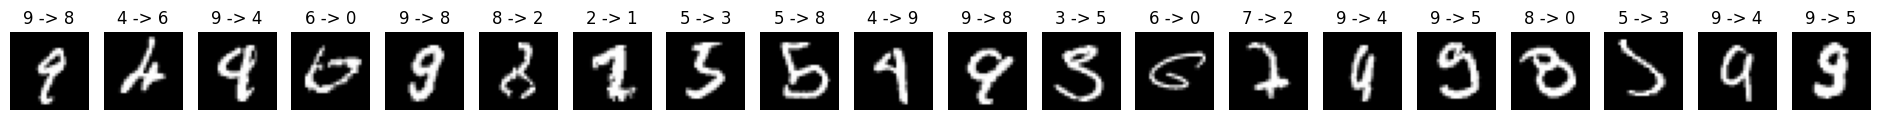

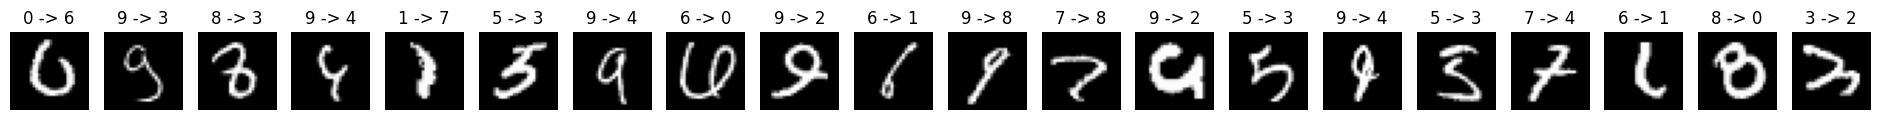

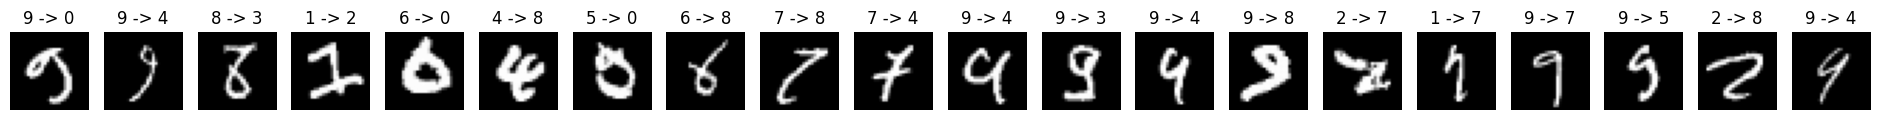

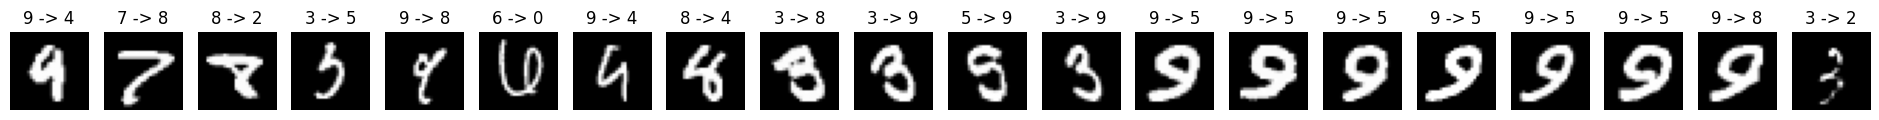



Correct Predictions:


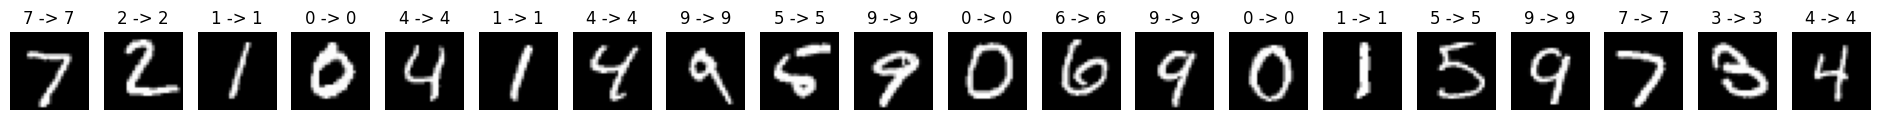

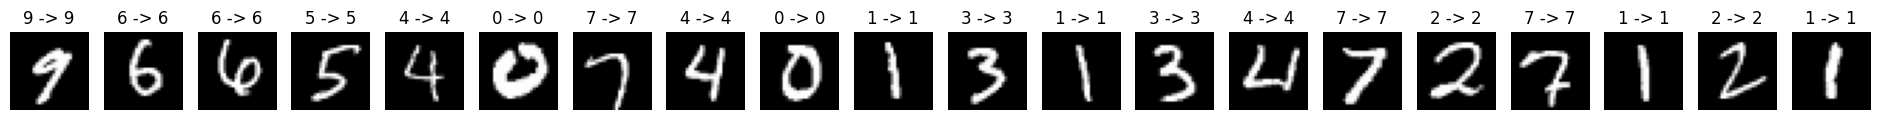

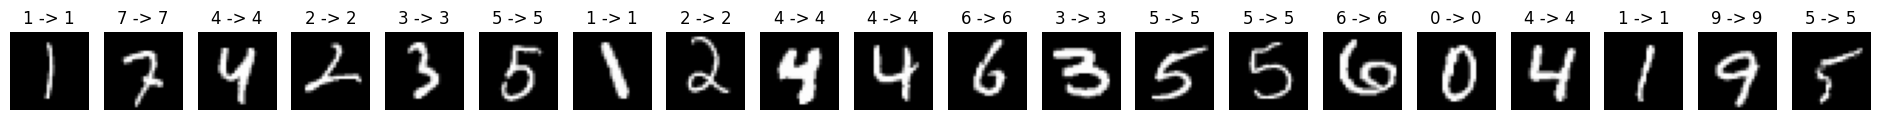

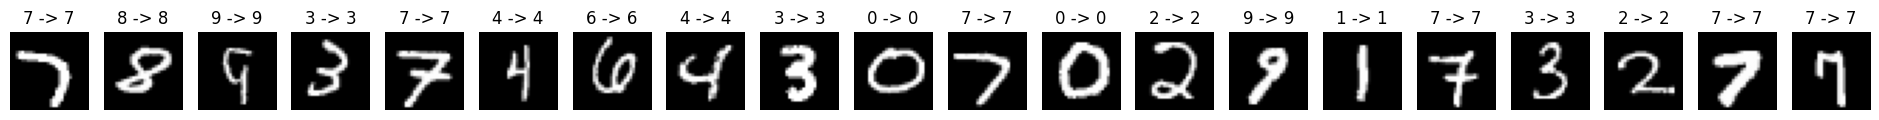

In [230]:
model.eval() # Set the model to evaluation mode
with torch.no_grad(): # Disable gradient calculation for inference
    correct = 0 # Initialize variable to track correct predictions
    total = 0 # Initialize variable to track total samples
    # Iterate through the test data in batches
    for i, (images, labels) in enumerate(test_loader):
        images = images.cuda() # Move images to the GPU
        labels = labels.cuda() # Move labels to the GPU

        outputs = model(images) # Forward pass: compute predicted outputs
        confidences = outputs.softmax(1) # Apply softmax to get confidence scores for each class
        _, predicted = torch.max(outputs.data, 1) # Get the predicted class with the highest probability
        correct_idx = predicted == labels # Create boolean mask for correct predictions
        incorrect_idx = predicted != labels # Create boolean mask for incorrect predictions

        if i == 0: # For the first batch
            correct_images = images[correct_idx] # Get correct images
            correct_labels = labels[correct_idx] # Get true labels for correct predictions
            correct_pred = predicted[correct_idx] # Get predicted labels for correct predictions
            correct_conf = confidences[correct_idx] # Get confidence scores for correct predictions

            incorrect_images = images[incorrect_idx] # Get incorrect images
            incorrect_labels = labels[incorrect_idx] # Get true labels for incorrect predictions
            incorrect_pred = predicted[incorrect_idx] # Get predicted labels for incorrect predictions
            incorrect_conf = confidences[incorrect_idx] # Get confidence scores for incorrect predictions
        else: # For subsequent batches, concatenate to existing tensors
            correct_images = torch.cat((correct_images, images[correct_idx]), 0) # Concatenate correct images
            correct_labels = torch.cat((correct_labels, labels[correct_idx]), 0) # Concatenate true labels for correct predictions
            correct_pred = torch.cat((correct_pred, predicted[correct_idx]), 0) # Concatenate predicted labels for correct predictions
            correct_conf = torch.cat((correct_conf, confidences[correct_idx]), 0) # Concatenate confidence scores for correct predictions

            incorrect_images = torch.cat((incorrect_images, images[incorrect_idx]), 0) # Concatenate incorrect images
            incorrect_labels = torch.cat((incorrect_labels, labels[incorrect_idx]), 0) # Concatenate true labels for incorrect predictions
            incorrect_pred = torch.cat((incorrect_pred, predicted[incorrect_idx]), 0) # Concatenate predicted labels for incorrect predictions
            incorrect_conf = torch.cat((incorrect_conf, confidences[incorrect_idx]), 0) # Concatenate confidence scores for incorrect predictions

print("Incorrect Predictions:") # Print header for incorrect predictions
plt_num = 20 # Number of images to plot in each row
for i in range(4): # Loop to display incorrect predictions in rows
    show_images_withPred(
        incorrect_images[i*plt_num:(i+1)*plt_num],
        incorrect_labels[i*plt_num:(i+1)*plt_num],
        incorrect_pred[i*plt_num:(i+1)*plt_num],
        incorrect_conf[i*plt_num:(i+1)*plt_num]
    )

print("\n\nCorrect Predictions:") # Print header for correct predictions
for i in range(4): # Loop to display correct predictions in rows
    show_images_withPred(
        correct_images[i*plt_num:(i+1)*plt_num],
        correct_labels[i*plt_num:(i+1)*plt_num],
        correct_pred[i*plt_num:(i+1)*plt_num],
        correct_conf[i*plt_num:(i+1)*plt_num]
    )

# Freeing memory by deleting large tensors after usage
del correct_images, correct_labels, correct_pred, correct_conf
del incorrect_images, incorrect_labels, incorrect_pred, incorrect_conf

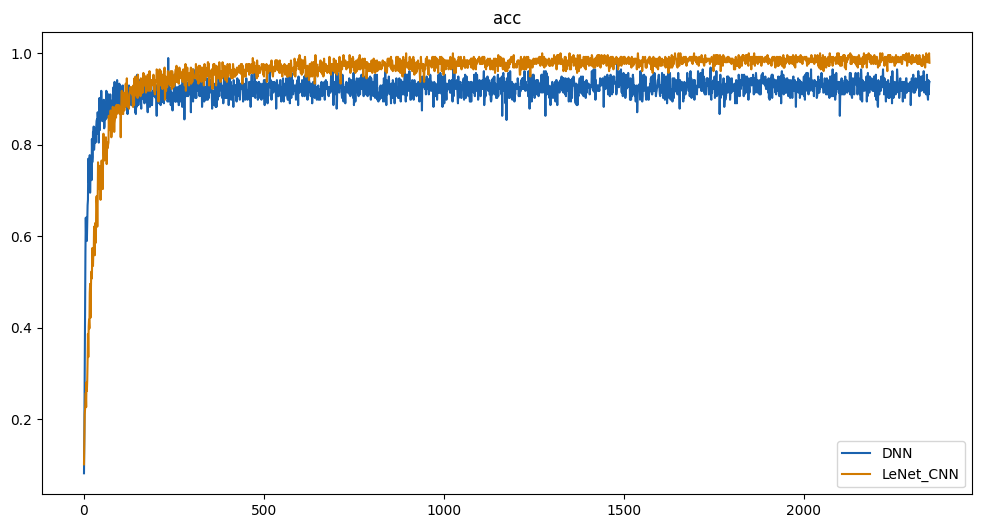

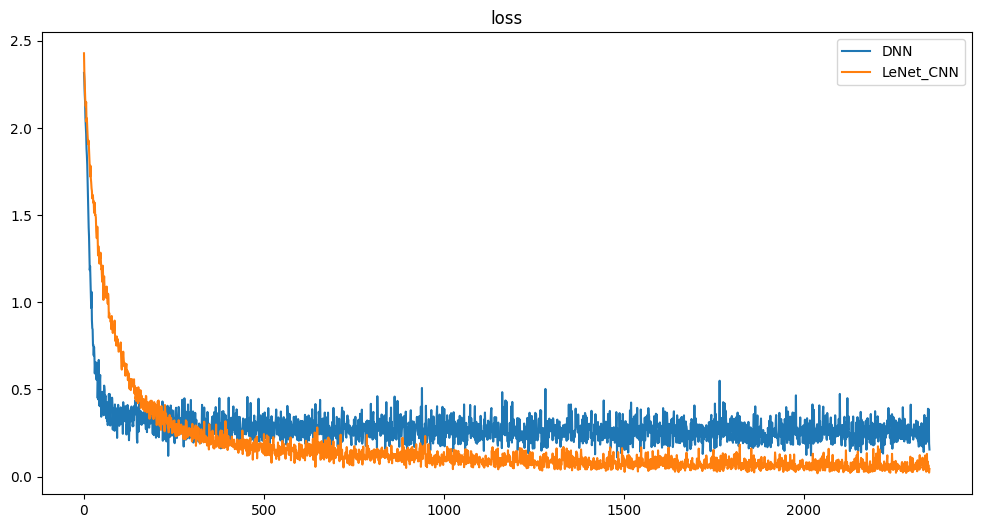

In [231]:
plt.figure(figsize=(12, 6))
plt.plot(acc_list, color='#1A62AE')  # Plot DNN accuracy with blue color
plt.plot(acc_list_cnn, color='#D17A00')  # Plot LeNet_CNN accuracy with orange color
plt.legend(['DNN', 'LeNet_CNN']) # Add a legend to distinguish the plots
plt.title('acc') # Set the title of the plot to 'acc'
plt.show() # Display the accuracy plot


plt.figure(figsize=(12,6)) # Create a new figure for the loss plot
plt.plot(loss_list) # Plot the DNN loss list
plt.plot(loss_list_cnn) # Plot the LeNet_CNN loss list
plt.legend(['DNN','LeNet_CNN']) # Add a legend to distinguish the plots
plt.title('loss') # Set the title of the plot to 'loss'
plt.show() # Display the loss plot